In [9]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from sklearn.linear_model import LinearRegression


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import hmmviterbi_vonmises, hmmdecode_vonmises
from hmm_utils import *
from simulation_utils import * 
from simulation import simulateBCIFitts

# for a reproducible result
np.random.seed(42)
fig_path = 'C:/Users/ghwilson/Box/GuyWilson_Files/nonstationarities_project/paper_figures/figures/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **Distortion matrix analysis with channel sweep**

This section looks at distortion matrix properties (axis-aligned shifts, rotations between X and Y subspaces) as a function of channel count.
For large d, we predict that:

$D^{T}E' \rightarrow Diag(\alpha, \alpha)$ 

where alpha is the shrinkage factor of our original PD tuning matrix E and $E' = \alpha E + \epsilon \ \ $  where $\epsilon \sim N(0, \sigma^{2})^{nx2}$

In [2]:
def getDistortionMatrix(dec, enc):
    '''
    Get distortion matrix D^T * E. Inputs are:
    
        dec (2D array) - n_channels x 2 array
        enc (2D array) - n_channels x 2 array 
    '''    
    distort  = dec.T.dot(enc)
    
    return distort

In [3]:
# general settings:
channel_sweep = np.array([10, 30, 50, 70, 100, 150, 200, 500, 1000])
nSimSteps     = 100000
n_repeats     = 1000
tuning_shift  = [0.8, 0.01, 0.0]  # PD shrinkage, new tuning variance, and mean shift 
renormalize   = False             # whether or not to adjust new tuning vectors to have same norm as initial
SNR           = 0.005             # SNR "per unit" (for ~200 channels, SNR = 1)


#-----------------------------------------
distortion_mats = np.zeros((len(channel_sweep), n_repeats, 2, 2)) 
 
for i, nUnits in enumerate(channel_sweep):
    initialTuning  = generateUnits(n_units = nUnits, SNR = SNR * nUnits)
    D              = np.copy(initialTuning[:, 1:]) 
    D             /= np.linalg.norm(D, axis = 0)**2
    
    for j in range(n_repeats):
        tuning  = simulateTuningShift(np.copy(initialTuning), PD_shrinkage = tuning_shift[0], PD_noisevar = tuning_shift[1], mean_shift = tuning_shift[2], renormalize = renormalize)
        distmat = getDistortionMatrix(D, tuning[:, 1:]) 
    
        distortion_mats[i,j,:,:] = distmat
        
   # print(np.linalg.norm(initialTuning, axis = 0))
   # print(np.linalg.norm(tuning, axis = 0))
    print(nUnits, ' channel setting finished')
    print('----------------------------------')
    

10  channel setting finished
----------------------------------
30  channel setting finished
----------------------------------
50  channel setting finished
----------------------------------
70  channel setting finished
----------------------------------
100  channel setting finished
----------------------------------
150  channel setting finished
----------------------------------
200  channel setting finished
----------------------------------
500  channel setting finished
----------------------------------
1000  channel setting finished
----------------------------------


In [4]:
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

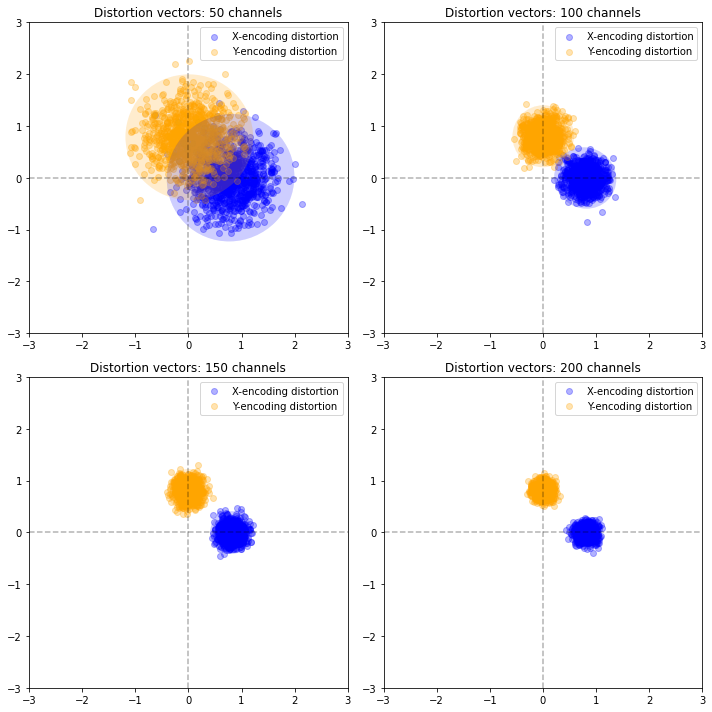

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse


figSize(10, 10)

labels      = ['X-encoding distortion', 'Y-encoding distortion']
color       = ['b', 'orange']
plot_values = [50, 100, 150, 200]


for i, nUnits in enumerate(plot_values):
    ind = np.where(channel_sweep == nUnits)[0]
    plt.subplot(2, 2, i + 1)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axvline(0, color = 'k', linestyle = '--', alpha = 0.3)
    plt.axhline(0, color = 'k', linestyle = '--', alpha = 0.3)
    for j in range(2):
        xvals = distortion_mats[ind, :, 0, j]
        yvals = distortion_mats[ind, :, 1, j]
        ax    = plt.gca()

        ellipse = confidence_ellipse(xvals, yvals, ax = ax, n_std = 3, facecolor = color[j], alpha = 0.1)
        ax.add_patch(ellipse)
        plt.scatter(xvals, yvals, color = color[j], alpha = 0.3, label = labels[j])
    
    plt.title('Distortion vectors: ' + str(nUnits) + ' channels')
    plt.legend()
    
plt.tight_layout()
plt.savefig(fig_path + 'distortion/example_channelCounts', format = 'pdf')

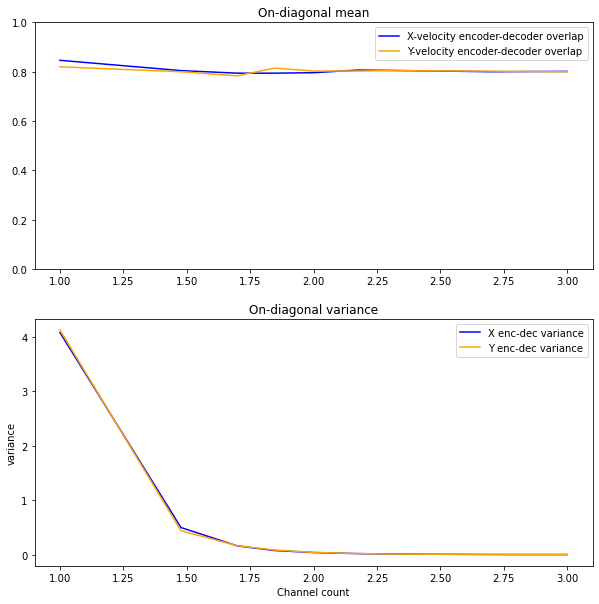

In [11]:
x_covs  = np.zeros((len(channel_sweep), 2, 2)) 
x_means = np.zeros((len(channel_sweep), 2 ))
y_covs  = np.zeros((len(channel_sweep), 2, 2)) 
y_means = np.zeros((len(channel_sweep), 2 ))

for i, nUnits in enumerate(channel_sweep):
    x_covs[i, :, :] = np.cov(distortion_mats[i, :, :, 0].T)
    x_means[i, :]   = np.mean(distortion_mats[i, :, :, 0], axis = 0)
    y_covs[i, :, :] = np.cov(distortion_mats[i, :, :, 1].T)
    y_means[i, :]   = np.mean(distortion_mats[i, :, :, 1], axis = 0)
    
figSize(10, 10)

plt.subplot(2, 1, 1)
plt.plot(np.log10(channel_sweep), x_means[:, 0], label = 'X-velocity encoder-decoder overlap', color = color[0])
plt.plot(np.log10(channel_sweep), y_means[:, 1], label = 'Y-velocity encoder-decoder overlap', color = color[1])
plt.title('On-diagonal mean')
plt.ylim([0, 1])
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.log10(channel_sweep), x_covs[:, 0, 0], label = 'X enc-dec variance', color = color[0])
plt.plot(np.log10(channel_sweep), y_covs[:, 1, 1], label = 'Y enc-dec variance', color = color[1])

plt.xlabel('Channel count')
plt.ylabel('variance')
plt.title('On-diagonal variance')
plt.legend()
plt.savefig(fig_path + 'distortion/all_channelCounts', format = 'pdf')